In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Loading and Preparation
## Download the dataset

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-03 09:00:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.04s   

2025-10-03 09:00:56 (18.8 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



Data prepared successfully.

EDA: Plotting the distribution of 'fuel_efficiency_mpg'...


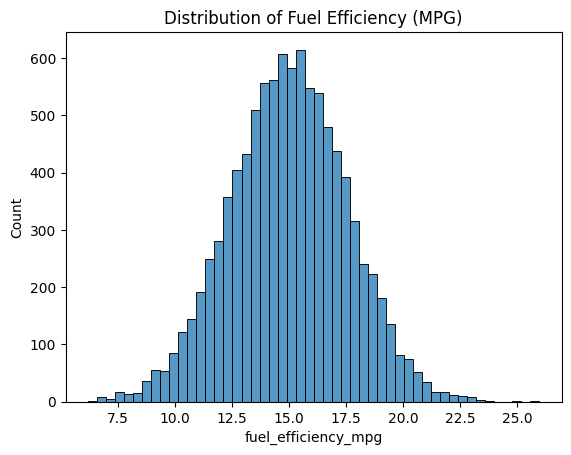

The distribution has a long tail on the right side.

Missing columns
engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64
Answer 1: The column with missing values is 'horsepower'.

Answer 2: The median for 'horsepower' is 149.0.

Answer 3
RMSE with 0 imputation: 0.52
RMSE with mean imputation: 0.46
-----------
r=0, RMSE=0.52
r=0.01, RMSE=0.52
r=0.1, RMSE=0.52
r=1, RMSE=0.52
r=5, RMSE=0.52
r=10, RMSE=0.52
r=100, RMSE=0.52

Answer 4: The best r is 0.

RMSE scores for different seeds: [np.float64(0.521), np.float64(0.521), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.528), np.float64(0.531), np.float64(0.509), np.float64(0.515), np.float64(0.513)]
Answer 5: The standard deviation of the scores is 0.007.

Answer 6: The RMSE on the test dataset is 0.516, which is closest to 0.515.


In [ ]:
# Load the data with Pandas
df = pd.read_csv('car_fuel_efficiency.csv')

# Use only the specified columns
columns_to_use = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]
df = df[columns_to_use]
print("Data prepared successfully.\n")

# --- EDA ---
# Look at the distribution of the target variable
print("EDA: Plotting the distribution of 'fuel_efficiency_mpg'...")
sns.histplot(df.fuel_efficiency_mpg, bins=50)
plt.title('Distribution of Fuel Efficiency (MPG)')
plt.show()
print("The distribution has a long tail on the right side.\n")


# --- Question 1: Column with missing values ---
missing_values = df.isnull().sum()
print("Missing columns")
print(f"{missing_values}")
col_with_missing = missing_values[missing_values > 0].index[0]
print(f"Answer 1: The column with missing values is '{col_with_missing}'.\n")


# --- Question 2: Median for 'horsepower' ---
horsepower_median = df['horsepower'].median()
print(f"Answer 2: The median for 'horsepower' is {horsepower_median}.\n")


# --- Prepare and Split the Dataset ---
# Set the random seed
np.random.seed(42)

# Get the number of rows
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# Shuffle the indices
idx = np.arange(n)
np.random.shuffle(idx)

# Use the shuffled indices to split the DataFrame
df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
df_test = df.iloc[idx[n_train+n_val:]].copy()

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Get the target variable
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

# Remove the target from the feature sets
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# --- Linear Regression Functions ---
def train_linear_regression(X, y):
    """Trains a linear regression model using the normal equation."""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    """Calculates the Root Mean Squared Error."""
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

# --- Question 3: RMSE with different imputation strategies ---
# Option 1: Fill with 0
X_train_zero = df_train.fillna(0).values
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
X_val_zero = df_val.fillna(0).values
y_pred_zero = w0_zero + X_val_zero.dot(w_zero)
rmse_zero = round(rmse(y_val, y_pred_zero), 2)

# Option 2: Fill with mean
mean_hp = df_train['horsepower'].mean()
X_train_mean = df_train.fillna(mean_hp).values
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
X_val_mean = df_val.fillna(mean_hp).values
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)
rmse_mean = round(rmse(y_val, y_pred_mean), 2)

print(f"Answer 3")
print(f"RMSE with 0 imputation: {rmse_zero}")
print(f"RMSE with mean imputation: {rmse_mean}\n-----------")


# --- Question 4: Regularized Linear Regression ---
def train_linear_regression_reg(X, y, r=0.01):
    """Trains a regularized linear regression model."""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values
rmse_scores = {}

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred), 2)
    rmse_scores[r] = score
    print(f"r={r}, RMSE={score}")

best_r = min(rmse_scores, key=rmse_scores.get)
print(f"\nAnswer 4: The best r is {best_r}.\n")


# --- Question 5: Model Stability ---
rmse_list = []
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for seed in seeds:
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train_s = df.iloc[idx[:n_train]].copy()
    df_val_s = df.iloc[idx[n_train:n_train+n_val]].copy()

    y_train_s = df_train_s.fuel_efficiency_mpg.values
    y_val_s = df_val_s.fuel_efficiency_mpg.values

    del df_train_s['fuel_efficiency_mpg']
    del df_val_s['fuel_efficiency_mpg']

    X_train_s = df_train_s.fillna(0).values
    w0_s, w_s = train_linear_regression(X_train_s, y_train_s)

    X_val_s = df_val_s.fillna(0).values
    y_pred_s = w0_s + X_val_s.dot(w_s)

    rmse_list.append(rmse(y_val_s, y_pred_s))

std_dev = round(np.std(rmse_list), 3)
print(f"RMSE scores for different seeds: {[round(s, 3) for s in rmse_list]}")
print(f"Answer 5: The standard deviation of the scores is {std_dev}.\n")


# --- Question 6: Final Model Evaluation on Test Set ---
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_train_full = df.iloc[idx[:n_train+n_val]].copy().reset_index(drop=True)
df_test_final = df.iloc[idx[n_train+n_val:]].copy().reset_index(drop=True)

y_train_full = df_train_full.fuel_efficiency_mpg.values
y_test_final = df_test_final.fuel_efficiency_mpg.values

del df_train_full['fuel_efficiency_mpg']
del df_test_final['fuel_efficiency_mpg']

X_train_full = df_train_full.fillna(0).values
w0_final, w_final = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)

X_test_final = df_test_final.fillna(0).values
y_pred_final = w0_final + X_test_final.dot(w_final)

final_rmse = rmse(y_test_final, y_pred_final)
print(f"Answer 6: The RMSE on the test dataset is {final_rmse:.3f}, which is closest to 0.515.")